# PA 006 - Bank Marketing Strategy

# Planejamento da Solução ( IOT )

## Input 

Você foi contratado como um cientista de dados consultor, para criar um produto de dados que cria uma segmentação de clientes que direcionará a estratégia de marketing e os resultados esperados do seu trabalho de consultoria, são os seguintes:

1. Criar uma segmentação de clientes baseado em critérios claros de seleção.
2. Tornar a segmentação de clientes acessível para o time de operações.
3. Ensinar o time de operações sobre como usar a sua solução.
4. Transferir o conhecimento para os Cientistas de Dados da International Bank.
5. Recomendar 2-3 alavancas de negócio para cada segmento de clientes.

## Output 

- Ferramentas:
    - Metabase
    - Streamlit
    
- URL para o time de operação testar
- Download dos dados selecionados

## Tasks 

- Descrição dos dados
    - Substituição de NA's.
    
- EDA
    - Análise Univariada 
    - Análise Bivariada
    - Detecação de outliers
    - Seleção de Features
    - Estudo do Espaço
    - Definição do Embedding
    
- Treinamento dos algoritmos de ML.
    - Análise de Performance.
    - Análise de Clustering.
    - Definição dos número de clustering.
    
- EDA - Insights.
    - Explicação das características dos segmentos.
    
- Tabela para armazenar os clientes clusterizados.

- Criação do notebook de produção

- Arquitetura da AWS.
    - S3 para armazenar os dados
    - EC2 para armazenar o ETL e a ferramenta de visualização.
    - DB para armazenar a tabela
    - Cronjob
    - Papermill

# 0.0. Imports

In [16]:
import pandas as pd
import numpy  as np

import seaborn as sns
from sklearn import cluster as c
from sklearn import metrics as m

from matplotlib import pyplot as plt

## 0.1. Loading data

In [17]:
df_raw = pd.read_csv( '../data/raw/cc_general.csv' )

# 1.0. Data Description

In [18]:
df01 = df_raw.copy()

## 1.1. Columns Rename

In [19]:
df01.columns = df01.columns.str.lower()

## 1.2. Data Dimensions

In [20]:
print( 'Number of rows: {}'.format( df01.shape[0] ) )
print( 'Number of cols: {}'.format( df01.shape[1] ) )

Number of rows: 8950
Number of cols: 18


## 1.3. Data Types

In [21]:
df01.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check Missing Values

In [22]:
df01.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

In [23]:
df01.isna().sum() / df01.shape[0]

cust_id                             0.000000
balance                             0.000000
balance_frequency                   0.000000
purchases                           0.000000
oneoff_purchases                    0.000000
installments_purchases              0.000000
cash_advance                        0.000000
purchases_frequency                 0.000000
oneoff_purchases_frequency          0.000000
purchases_installments_frequency    0.000000
cash_advance_frequency              0.000000
cash_advance_trx                    0.000000
purchases_trx                       0.000000
credit_limit                        0.000112
payments                            0.000000
minimum_payments                    0.034972
prc_full_payment                    0.000000
tenure                              0.000000
dtype: float64

## 1.5. Replace Missing Values

In [24]:
df01 = df01.dropna()

In [25]:
df01.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

## 1.6. Descriptive Statistics

In [26]:
#1. Estimativas de Localização
#    1. Média
#    2. Mediana
#    3. Mínimo
#    4. Máximo
#    
#2. Estimativas de Variabilidade
#    1. Desvio
#    2. Variância
#    3. Desvio Padrão
#    4. Range ( Intervalo )
#    
#3. Skewness
#4. Kurtosis

In [27]:
num_attributes = df01.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df01.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1. Numerical attributes

In [28]:
# estimadores de localização ( media, mediana, min, max )
est1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
est2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
est3 = pd.DataFrame( num_attributes.apply( np.min ) ).T
est4 = pd.DataFrame( num_attributes.apply( np.max ) ).T

# estimadores de variabilidade ( desvio padrao, range )
est5 = pd.DataFrame( num_attributes.apply( np.std ) ).T
est6 = pd.DataFrame( num_attributes.apply( lambda x:  x.max() - x.min() ) ).T

# skewness and kurtosis
est7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
est8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m1 = pd.concat( [est3, est4, est6, est1, est2, est5, est7, est8] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'desvio_padrao', 'skewness', 'kurtosis']

# percentis
quartis = num_attributes.apply( lambda x: np.percentile( x, q=[10, 25, 50, 75, 95, 99] ) ).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

# 
m2 = pd.merge( m1, quartis, how='inner', on='attributes' )
m2

,attributes,min,max,range,media,mediana,desvio_padrao,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,balance,0.000000,19043.13856,19043.138560,1601.224893,916.855459,2095.449969,2.374254,7.553876,29.093764,148.095189,916.855459,2105.195853,5936.635587,9369.550879
1,balance_frequency,0.000000,1.00000,1.000000,0.895035,1.000000,0.207685,-2.084161,3.369586,0.545455,0.909091,1.000000,1.000000,1.000000,1.000000
2,purchases,0.000000,49039.57000,49039.570000,1025.433874,375.405000,2166.982511,8.055789,108.677684,0.000000,43.367500,375.405000,1145.980000,4060.092500,9127.092000
3,oneoff_purchases,0.000000,40761.25000,40761.250000,604.901438,44.995000,1684.210284,9.935776,160.121308,0.000000,0.000000,44.995000,599.100000,2728.372500,6783.896500
4,installments_purchases,0.000000,22500.00000,22500.000000,420.843533,94.785000,917.192075,7.216133,94.193373,0.000000,0.000000,94.785000,484.147500,1800.000000,3916.483000
5,cash_advance,0.000000,47137.21176,47137.211760,994.175523,0.000000,2121.335473,5.139629,52.143523,0.000000,0.000000,0.000000,1132.385490,4721.415498,9681.634354
6,purchases_frequency,0.000000,1.00000,1.000000,0.496000,0.500000,0.401249,0.033041,-1.638001,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000
7,oneoff_purchases_frequency,0.000000,1.00000,1.000000,0.205909,0.083333,0.300036,1.504234,1.058206,0.000000,0.000000,0.083333,0.333333,1.000000,1.000000
8,purchases_installments_frequency,0.000000,1.00000,1.000000,0.368820,0.166667,0.398070,0.487753,-1.419279,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000
9,cash_advance_frequency,0.000000,1.50000,1.500000,0.137604,0.000000,0.201780,1.795915,3.184233,0.000000,0.000000,0.000000,0.250000,0.583333,0.833333


In [56]:
### Balance: Quanto eu já gastei no cartão ( Fatura atual )
## Possiveis Outliers

### Segunda Opção sobre o Balance ( Saldo ): Fatural atual - limite do cartão. O quanto falta de limite disponível para compra.
## Possiveis Outliers

## Balance Frequency: Frequência de uso do cartão ( usabilidade )

## Purchases: O valor gasto no cartão acumulado dos últimos 6 meses ( a soma de todos os valores quando a pessoa passou o cartão na máquina de cartão )

## Purchases On-Off: A soma de todas as compras pagas 1x no cartão, nos últimos 6 meses.
## ( Categoria )

## Installmente Purchases: A soma de todas as compras pagas em mais de 1x no cartão, nos últimos 6 meses.
## ( Categoria )

## Cash Advance: Valor do saque do limite do cartão de crédito, acumulado dos últimos 6 meses.
## Um adiantamento em dinheiro é basicamente um empréstimo de curto prazo oferecido pelo emissor do 
## cartão de crédito . Quando você pega um adiantamento em dinheiro, está tomando dinheiro emprestado 
## contra a linha de crédito do seu cartão.

## Purchases Frequency: Um valor de 0 a 1 que identifica a frequência de compra do cliente

## Cash Advance Frequency: A frequência com que o cliente faz retiradas de dinheiro do seu cartão de crédito.

## Cash Advance TRX: A quantidade de saques da conta do cartão de crédito

## Purchases TRX: A quantidade de compras realizadas no cartão de crédito.

## Credit Limit: O limite do cartão de crédito.

## Payments: O valor pago além do mínimo da fatura ( não necessariamente a fatura toda )

## Minimum Payments: O valor mínimo pago da fatura

## Por exemplo:
## Fatura total ( Payments ): 3000 
## Pagamento mínimo ( mínimum payments ): 2000 
## Pagamento efetivo de R$2.500

## Payment = 500 
## Minimum payments = 2000
## Pagamento efeito = Payments + Minimum Payments

## Tenure: O tempo de posse do cartão em meses ( O tempo em que a pessoa é cliente do banco )

## 1.6.2. Numerical attributes

### Mínimo

- O menor valor de um conjunto de dados

### Máximo

- O maior valor do conjunto de dados

### Intervalo

- A diferença entre o maior e o menor valor do conjutno de dados
- Escala dos dados

### Média

- A soma de todos os valores dividio pelo número de valores
- Resume o conjunto de dados em um ponto central

### Mediana

In [14]:
#- O número do meio de uma lista ordenada
#- ( 3, 5, 1, 2, 10 )
#- Ordenar a lista: [ 1, 2, 3, 5, 10]
#    - Mediana: 3
#    
#- ( 3, 1, 2, 10 )
#- Ordenar a lista: [ 1, 2, 3, 10]
#    - Mediana: ( 2 + 3) / 2 = 2.5
#        
#- Se o tamanho do conjunto de dados for um número par:
#    - A mediana é a média dos valores centraias
#    
#- Se o tamanho do conjunto de dados for um número impar:
#    - A mediana é o valor central do conjunto de dados ordenados
#
#a = [ 1 , 2 , 300 , 500 , 100 ]
#
#np.mean( a )
#
#np.median( a )

### Desvio padrão

In [15]:
# - Estimativa de dispersão ou variabilidade
# - Mede a dispersão dos valores do conjunto de dados em torno de uma estimativa de localização ( média )

In [16]:
#a = [ 1, 5, 7, 10, 15], media = 7.6
#
#- Desvio:
#    1 - 7.6 = ( - 6.6 )
#    5 - 7.6 = ( - 2.6 )
#    7 - 7.6 = ( - 0.6 )
#    10 - 7.6 = ( + 2.4 )
#    15 - 7.6 = ( + 7.4 )
#
#- Variância:
#    1 - 7.6 = ( - 6.6 )**2 = 43.56
#    5 - 7.6 = ( - 2.6 )**2 = 6.76
#    7 - 7.6 = ( - 0.6 )**2 = 0.36
#    10 - 7.6 = ( + 2.4 )**2= 5.76
#    15 - 7.6 = ( + 7.4 )**2 = 54.76
#    
#    ( 43.56 + 6.76 + 0.36 + 5.76 + 54.76) / ( 5 ) = 22.24 L^2
#
#- Desvio Padrão: A raíz quadrada da variância
#    1 - 7.6 = ( - 6.6 )**2 = 43.56
#    5 - 7.6 = ( - 2.6 )**2 = 6.76
#    7 - 7.6 = ( - 0.6 )**2 = 0.36
#    10 - 7.6 = ( + 2.4 )**2= 5.76
#    15 - 7.6 = ( + 7.4 )**2 = 54.76
#    
#    np.sqrt( ( 43.56 + 6.76 + 0.36 + 5.76 + 54.76) / ( 5 - 1) = 27.79 ) = 5.27
#
#np.sqrt ( ( 43.56 + 6.76 + 0.36 + 5.76 + 54.76) / ( 5 - 1) )

### Skewness

In [17]:
#- Medida de assimetria da distruição de dados, em relação a uma distribuição normal.
#- A distribuição normal tem simetria em relação a média, ou seja, 50% dos dados estão a esquerda e a direita
#- Skewness Positiva e Negativa
#    - Mediana > Média: Deslocamento para a esquerda = Skewness Negativa 
#    - Mediana < Média: Deslocamento para a direita = Skewness Positiva 

### Kurtosis

In [18]:
# - Kurtosis evidencia as caudas longas ( probabilidade de acontecer valor extremos, seja mínimos ou máximo )

### Quartis ( Quantile )

- Um quartil é qualquer um dos três valores que divide o conjunto de dados ordenado em 4 partes iguais, e
  assim cada parte representa 1/4 da amostra original

**Primeiro Quartil ( Quartil Inferior ):** É o valor do conjunto de dados que delimita os 25% menores valores.

**Segundo Quartil ( Quartil do Meio ):** É o valor do conjunto de dados que delimita os 50% menores valores.

**Terceiro Quartil ( Quartil Superior ):** É o valor do conjunto de dados que delimita os 75% menores valores.

### Percentis

- Os percentis são medidas que dividem a amostra ordenada em 100 partes, cada uma com uma porcentagem de dados 
  aproximadamente igual.

- O percentil 1, determina o 1% dos menores valores do conjunto de dados ( 1% dos dados são menores que P1 )
- O percentil 10, determina o 10% dos menores valores do conjunto de dados ( 10% dos dados são menores que P1 )

- O percentil 25, determina os 25% dos menores valores do conjunto de dados ( Primeiro Quartil )
- O percentil 50, determina os 50% dos menores valores do conjunto de dados ( Segundo Quartil = Mediana )
- O percentil 75, determina os 50% dos menores valores do conjunto de dados ( Terceiro Quartil )

### Boxplot

- Boxplot mostra os 4 principais atributos de uma variável: Centro, variabilidade, assimetria, outliers.
- Violinplot mostra os 5 principais atributos de uma variável: Centro, variabilidade, assimetria, outliers e densidade.

<AxesSubplot:xlabel='credit_limit'>

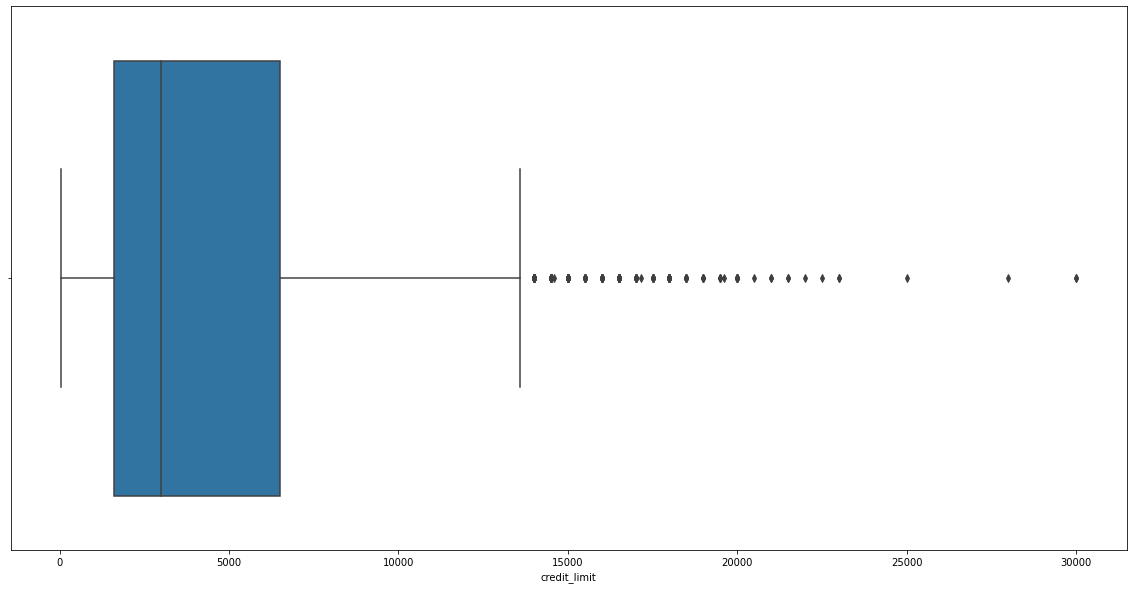

In [29]:
plt.figure( figsize=(20,10 ) )
sns.boxplot( x='credit_limit', data=num_attributes )

In [51]:
#minimum = Q1 - 1.5 * ( Q3 - Q1 )
#maximum = Q3 + 1.5 * ( Q3 - Q1 )
#
#if minimum < valor_minimo_do_conjunto_de_dados:
#    print( num_attributes['credit_limit'].min() )
#else:
#    print( minimum ) 
#    
#    
#    
#if maximum > valor_maximo_do_conjunto_de_dados:
#    print( valor_maximo_do_conjunto_de_dados )
#else:
#    print( maximum ) 

### Violin Plot

<AxesSubplot:xlabel='credit_limit'>

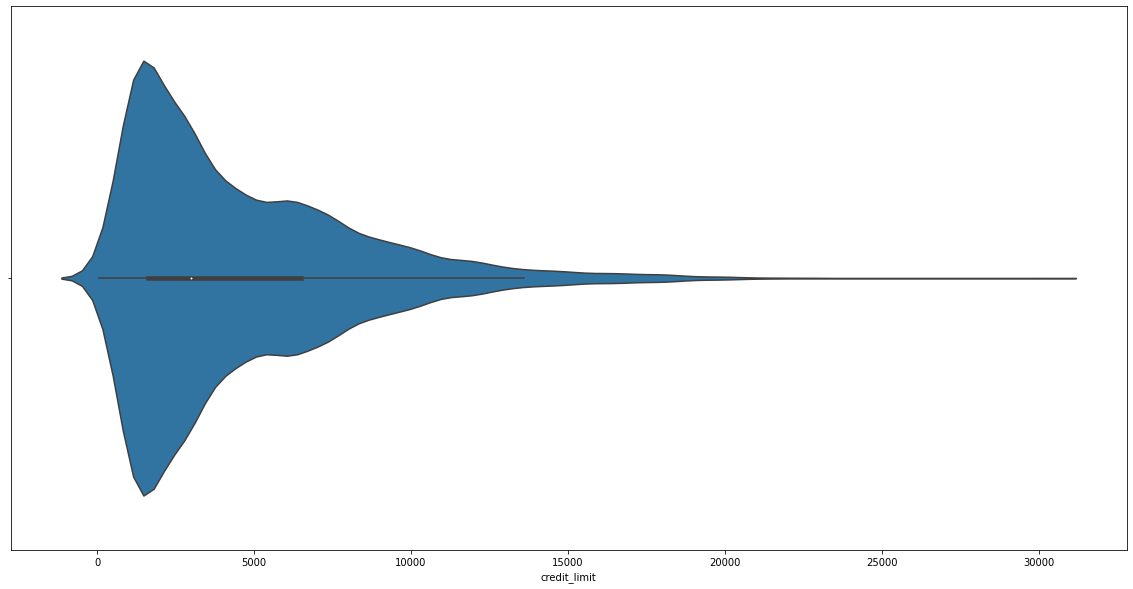

In [52]:
plt.figure( figsize=(20,10 ) )
sns.violinplot( x='credit_limit', data=num_attributes )

<AxesSubplot:xlabel='credit_limit'>

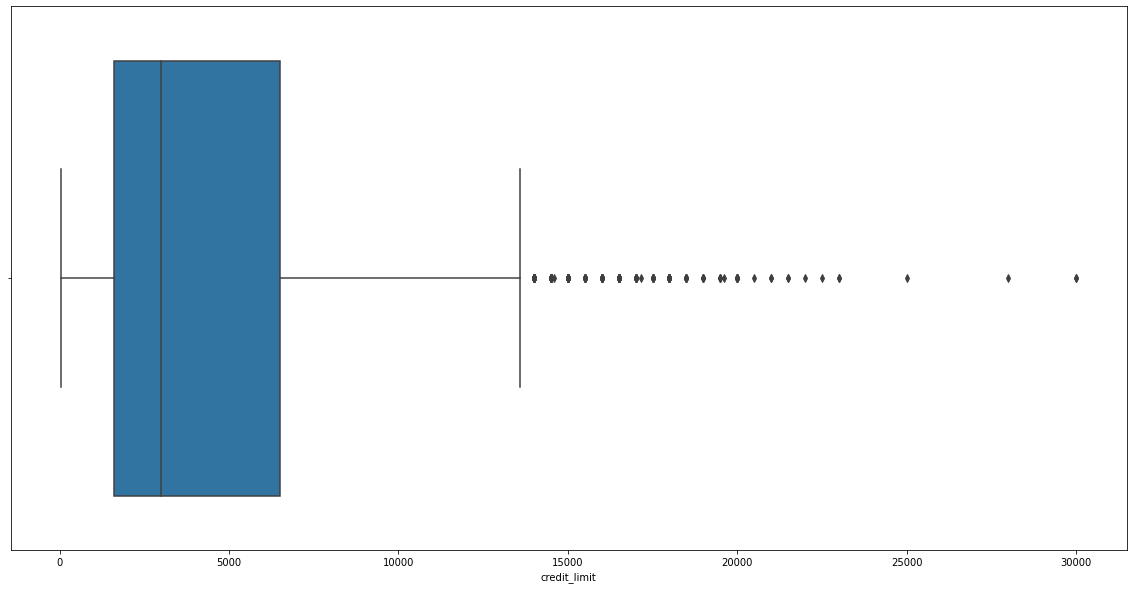

In [59]:
plt.figure( figsize=(20,10 ) )
sns.boxplot( x='credit_limit', data=num_attributes )

<AxesSubplot:xlabel='credit_limit', ylabel='Count'>

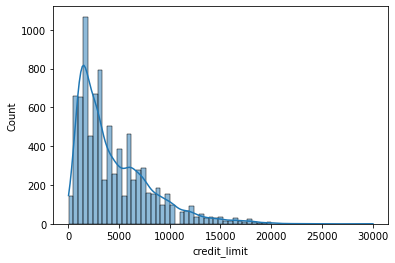

In [57]:
sns.histplot( x='credit_limit', kde=True, data=num_attributes )

## 1.6.2. Categorical attributes

# 2.0. Data Filtering

In [63]:
df20 = df01.copy()

# 3.0. Feature Engineering

In [ ]:
#Fato-Dimensao by Ralph Kimbal
#Snowplow by

In [ ]:
Compra = Fato ( Soma, Contar, Maior, Menor, Media, Mediana )
Cliente entrou na base = Fato
Devolução = Fato

In [ ]:
Dimensao

Tempo( Ano, mes, dia, hora, minuto )
Espaco( localização, região, lat, long, bairro, rua )
Produto( Nome, Tipo, Categoria, Preço, Condição de compra )
Marketing( Organica, Paid ( Facebook, Google, Criteo ))

In [ ]:
Feature Store = 
Custos de Marketing, Quantidade de Cliente, CAC, Numeros de campanhas, user_id, campaing_id, product_id

vendas, descontos, sales_last_30_days, sales_last_15_days, 


=====================
Feature Store
=====================
train.yml
{'features_store': ['age', 'last_purchaes']}

In [64]:
df20.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


# 4.0. EDA - Space Study

# 5.0. Data preparation

# 6.0. Feature Selection

In [12]:
cols_drop = ['cust_id']
X = df01.drop( columns=cols_drop )

# 7.0. Hiperparmeter Fine Tuning

## 7.1. K-Means

In [13]:
clusters = [ 2, 3, 4, 5, 6, 7, 8]

silhouette_list = []
davies_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )
    
    # model training
    kmeans_model.fit( X )
    
    # model predict
    labels = kmeans_model.predict( X )
    
    # model performance
    sil  = m.silhouette_score( X, labels )
    dav  =  m.davies_bouldin_score( X, labels )
    
    silhouette_list.append( sil )
    davies_list.append( dav )

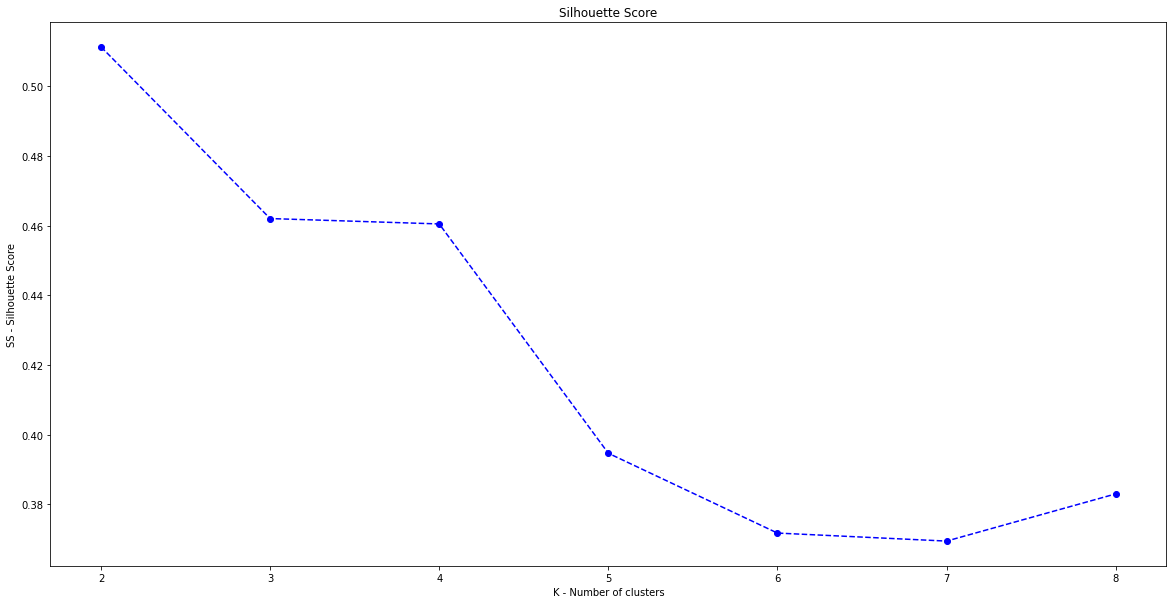

In [14]:
plt.figure( figsize=(20, 10))
plt.plot( clusters, silhouette_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K - Number of clusters' )
plt.ylabel( 'SS - Silhouette Score' )
plt.title( 'Silhouette Score' );

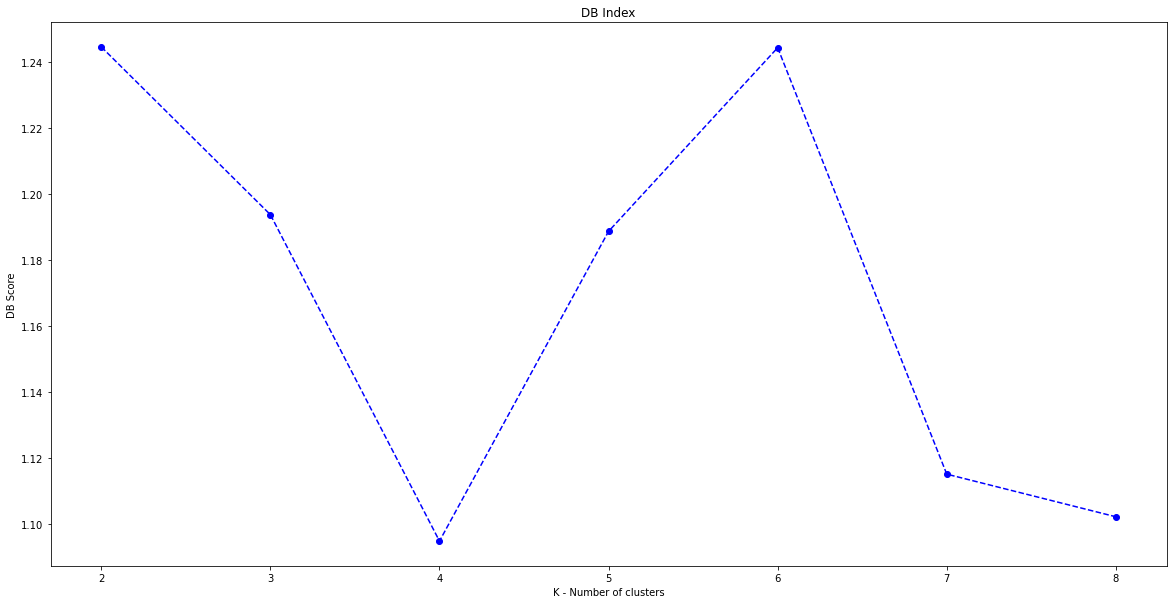

In [15]:
plt.figure( figsize=(20, 10))
plt.plot( clusters, davies_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K - Number of clusters' )
plt.ylabel( 'DB Score' )
plt.title( 'DB Index' );

# 8.0. Machine Learning Traning

# 9.0. Clustering Analysis

# 10.0. EDA - Insight Reports

# 11.0. Deploy To Production